# Research topic:   探討Ptt鄉民對於躺平族的的討論與看法

*   **課程:** 社群媒體分析
*   **學生:** M124020023 小胖子 M124020025吳安倢 M124020036 吳景煥 M124020020 李培聖
*   **爬取資料:** 2021-01-01 到 2024-04-18 的PTT閒聊板資料
*   **關鍵字:** 躺平、躺平族、不想努力了


### 躺平族情境介紹：

「你人生奮鬥的終點，是別人的起點」，這一句話道出了現在年輕人的掙扎無力感，當你人生不順遂，一路逆風努力了一輩子，發現成就還是不如別人，那還不如對自己好一點，直接躺平！

躺平族這一概念在近年來ptt掀起討論，象徵著對現代社會壓力和期望的一種抗議或無奈的應對方式。透過分析PTT上的討論，可以深入了解台灣社會對這種現象的看法和感受。
根據媒體研究，台灣人使用「躺平」這個次數在「2021年」快速產生！


### 分析動機：
* 年輕人為何拒絕奮鬥？有可能造成國安危機？
* 不再以買房、買車、生小孩為人生目標，「躺平才是唯一的真理」，年輕人對於未來普遍感到失望和無力，探討社會對於躺平現象的接受度和反應
* 分析躺平族現象對經濟活動、就業市場和消費行為的影響（如不消費、低生產），以及它可能對未來經濟發展的影響
* 透過分析PTT閒聊版上的討論，揭露大眾意見的形成與流動過程。分析媒體如何塑造對躺平族的觀點，以及這些觀點在台灣社會中如何傳播與轉變




#Import package

In [ ]:
# 安裝會使用到的套件
# %pip install ckiptagger[tf,gdown] wordcloud SnowNLP

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
import matplotlib
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io
from wordcloud import WordCloud, ImageColorGenerator
import time
from datetime import datetime, timedelta
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']

# 設定字型
FontPath = 'raw_data/SourceHanSansTW-Regular.otf' 

### Agonda

+ 1. 資料前置作業
    - 1.1 資料前處理
    - 1.2 資料清理
    - 1.3 移除停用字與斷詞
+ 2. Lexicon-base 情緒分析
    + 2.1 正負向情緒及聲量分數折線圖
    + 2.2 正負向情緒分數比例折線圖圖
    + 2.3 文字雲
    + 2.4 正負情緒代表字
    + 2.5 每日情緒分數趨勢
+ 3. CKIP
    + 3.1 CKIP安裝
    + 3.2 使用CKIP進行自然語言處理
    + 3.3 探索分析-NER
    + 3.4 探索分析-POS
+ 4. 利用SnowNLP進行情緒分析
+ 5. TF-IDF計算
    + 5.1 計算每個詞彙的TF-IDF
    + 5.2 檢視結果
+ 6. 透過結巴斷詞與N-gram幫助建立字典
    + 6.1 Bigram
    + 6.2 Trigram
    + 6.3 建立Ngram預測模型
    + 6.4 Bigram視覺化
    + 6.5 Pairwise correlation
    + 6.6 和「躺平」相關性最高的十個詞彙
    + 6.7 計算文章相似度
+ 7. 結論
    



### 1.資料前置作業

#### 1.1 資料前處理

In [5]:
#Import the dataset
MetaData = pd.read_csv('raw_data/Lie-Flat.csv')

#將artDate欄位只留下 年/月/日
MetaData['artDate'] = pd.to_datetime(MetaData['artDate']).dt.date

In [6]:
print(f"共有 {MetaData.shape[0]} 篇文章") #(row,column)
MetaData.head(1)

共有 625 篇文章


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt


### 1.2 資料清理


*   去除NA值
*   正規化資料清理
*   去除不是中文的字詞


In [7]:
#清理文章內容
clear_df = MetaData.copy()
#去除有包含空值的筆數
clear_df.dropna(axis = 0, how = 'any', inplace = True)

#去除不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate','dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)


#移除內文中的網址
clear_df['sentence'] = (
    clear_df['artContent']
    .replace(r'http\S+', '', regex = True)
    .replace(r'www\S+', '', regex = True)
    .replace(r'\d+', '', regex = True)
    .replace(r'\n\n','。', regex=True)
    .replace(r'\n' ,',', regex=True)
)

clear_df.head(10)

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"都第集了，,竟然沒人開這一檔閒聊，,這是一部顛覆的都市情感劇，,沒有白富美的女一，,也沒有高..."
1,https://www.ptt.cc/bbs/China-Drama/M.169899146...,[心得]沒有工作的一年,2023-11-03,因為在FB滑到[沒有工作的一年]給打工人的15大金句\n才開始注意到這部陸劇[沒有工作的一年...,"因為在FB滑到[沒有工作的一年]給打工人的大金句,才開始注意到這部陸劇[沒有工作的一年]。總..."
2,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n新唐人\n\n2.記者署名:\n羅...,"備註請放最後面 違者新聞文章刪除。.媒體來源:,新唐人。.記者署名:,羅婷婷。.完整新聞標題..."
3,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,[問卦]我就爛有另一種說法嗎?,2021-06-04,在日本有草食男或啃老族\n\n現在中國忽然來了一個躺平族\n\n那有沒有其他的說法比較文雅的...,"在日本有草食男或啃老族。現在中國忽然來了一個躺平族。那有沒有其他的說法比較文雅的。有沒有八卦,"
4,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,Re:[問卦]具體來說現在在等什麼,2021-06-06,依據人性\n\n1. 人是自私的，自己的利益優先考量\n2. 別人的不幸甜如蜜\n\n但是大...,"依據人性。. 人是自私的，自己的利益優先考量,. 別人的不幸甜如蜜。但是大家在等的都不一樣。..."
5,https://www.ptt.cc/bbs/Gossiping/M.1623985925....,[問卦]阿姨我不想努力了算不算躺平的掛??,2021-06-18,躺平族 尼特族 日本低慾望 韓國袋鼠族....等\n\n在台灣1450所造成的內捲下，名稱還...,躺平族 尼特族 日本低慾望 韓國袋鼠族....等。在台灣所造成的內捲下，名稱還沒有定義。所以...
6,https://www.ptt.cc/bbs/Gossiping/M.1624777902....,Re:[問卦]現今社會啃老多嗎?,2021-06-27,日本就一堆了叫啃老族\n\n美國稱迴力鏢族\n\n中國叫躺平族\n\n台灣也差不多\n\n但...,日本就一堆了叫啃老族。美國稱迴力鏢族。中國叫躺平族。台灣也差不多。但神奇的事如果是上代有錢代...
7,https://www.ptt.cc/bbs/Gossiping/M.1624811888....,[問卦]人生拚三次躺平退出社會競爭可恥嗎?,2021-06-28,"我有個朋友\n人生拚第一次讀研究所拚學位,拚四年無法拿到學位放棄\n人生拚第二次 三年考上公...","我有個朋友,人生拚第一次讀研究所拚學位,拚四年無法拿到學位放棄,人生拚第二次 三年考上公職 ..."
8,https://www.ptt.cc/bbs/Gossiping/M.1625541063....,Re:[問卦]好手好腳不工作整天接受施捨的叫?,2021-07-06,如果用人來看\n\n就是一個自宅警備隊\n\n每天蹲在家不工作\n\n都要靠父母接濟\n\n...,如果用人來看。就是一個自宅警備隊。每天蹲在家不工作。都要靠父母接濟。而且脾氣還很大。覺得自己...
9,https://www.ptt.cc/bbs/Gossiping/M.1625642776....,[問卦]台灣的躺平族或家裡蹲是不是比較少？,2021-07-07,這邊是跟中國日本比，中國開始流行躺平，那日本\n\n很早就開始有家裡蹲文化，而且老中少都有，...,這邊是跟中國日本比，中國開始流行躺平，那日本。很早就開始有家裡蹲文化，而且老中少都有，那台。...


### 1.3  斷句斷詞 與移除停用字

斷句

In [8]:
#清理符號
clear_df['sentence'] = clear_df['sentence'].astype(str).str.split("[,，。！!？?]{1,}")
sent_df = clear_df.explode("sentence").reset_index(drop=True)

#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)
sent_df = sent_df[sent_df["sentence"].str.len() > 1]
sent_df.head(10)

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,都第集了
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,竟然沒人開這一檔閒聊
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,這是一部顛覆的都市情感劇
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,沒有白富美的女一
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,也沒有高富帥的男一
5,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,也沒有悲催的北上廣生活
6,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,以女二何小雨躺平族的視角
7,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,來描述女一何大雨人生受挫失業的生活
8,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,女一辣目洋子充分運用她特有的美感
9,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,以及詼諧的演技演繹出北漂族的另外一種酸甜甘苦


斷詞及停用字處理

使用jieba套件進行斷詞與移除停用字

In [9]:
#設定繁體中文詞庫
jieba.set_dictionary("dict/dict.txt")
#新增自定義字典
jieba.load_userdict("dict/user_dict.txt")

Building prefix dict from /Users/wuanjie/Desktop/NLP/mid-project/dict/dict.txt ...
Dumping model to file cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.u9bb5604f6615f74065eb106a934eec11.cache
Loading model cost 2.488 seconds.
Prefix dict has been built successfully.


In [10]:
#對文章內容進行斷詞處理
word_df = (
    sent_df.assign(word=sent_df["sentence"].apply(jieba.lcut))
    .explode("word")
    .drop(["sentence"], axis=1)
)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head(10)

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,第集
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,竟然
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,沒人開
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,這一
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,閒聊
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,這是
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,一部
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,顛覆
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,都市
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,情感


去除停用字

In [11]:
freq_df = pd.DataFrame(pd.value_counts(word_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(10)

/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_20383/36027799.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df = pd.DataFrame(pd.value_counts(word_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


,word,count
0,躺平,1212
1,就是,433
2,台灣,431
3,自己,428
4,工作,373
5,現在,349
6,不是,314
7,沒有,314
8,可以,310
9,年輕人,289


In [12]:
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 

In [13]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df.head(10)

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,第集
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,沒人開
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,這一
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,閒聊
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,一部
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,顛覆
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,都市
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,情感
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,富美
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,富帥


計算詞頻

/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_20383/583685406.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


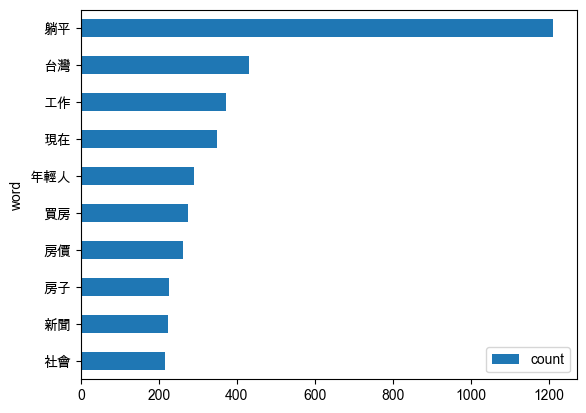

In [14]:
freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_nostop.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

*    詞頻的前十名與我們要做的主題高度相關，包含躺平、年輕人、房價等等詞彙，這些詞匯反映了分析文本中的熱門討論話題，可能指向年輕一代面臨的社會和經濟問題，例如：

- 躺平：這個詞彙指的是某些年輕人選擇的一種生活方式，即不追求過度勞累或高消費的生活，而是選擇一種無壓力和隨性的生活方式
- 房價：這是一個普遍關注的話題，尤其是對於在都市中工作生活的年輕人來說，高房價可能是一個重大的經濟負擔

繪製文字雲

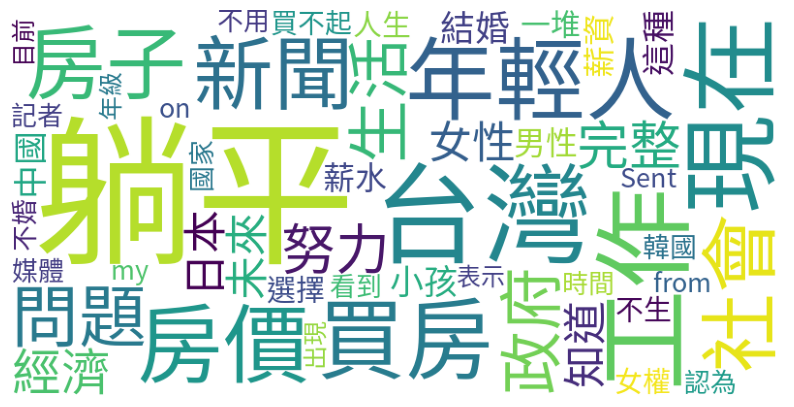

In [15]:
freq_dict_nostop = freq_df_nostop.set_index('word').to_dict()
freq_dict_nostop = freq_dict_nostop['count']

# 繪製文字雲
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_nostop.generate_from_frequencies(freq_dict_nostop)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

### 2. lexicon-base 情緒分析


*   進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併。
*   為了分析聲量，我們在此加入聲量字典(name)，以進行後續分析。

In [16]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [17]:
#將情緒字典與斷詞結果進行合併
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df

#Convert datetime
MetaData["artDate"] = pd.to_datetime(MetaData["artDate"])
MetaData["artDate"] = MetaData["artDate"].dt.date

In [18]:
ptt_liwc_df.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03,[閒聊]沒有工作的一年~~,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,第集,NaN
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03,[閒聊]沒有工作的一年~~,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,沒人開,NaN
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03,[閒聊]沒有工作的一年~~,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,這一,NaN
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03,[閒聊]沒有工作的一年~~,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,閒聊,NaN
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03,[閒聊]沒有工作的一年~~,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,一部,NaN


In [19]:
sentiment_count = ptt_liwc_df.groupby(['artDate','sentiments'],as_index=False).size()
sentiment_count.head()

,artDate,sentiments,size
0,2021-05-30,affect,60
1,2021-05-30,anger,17
2,2021-05-30,anx,9
3,2021-05-30,negative,44
4,2021-05-30,positive,9


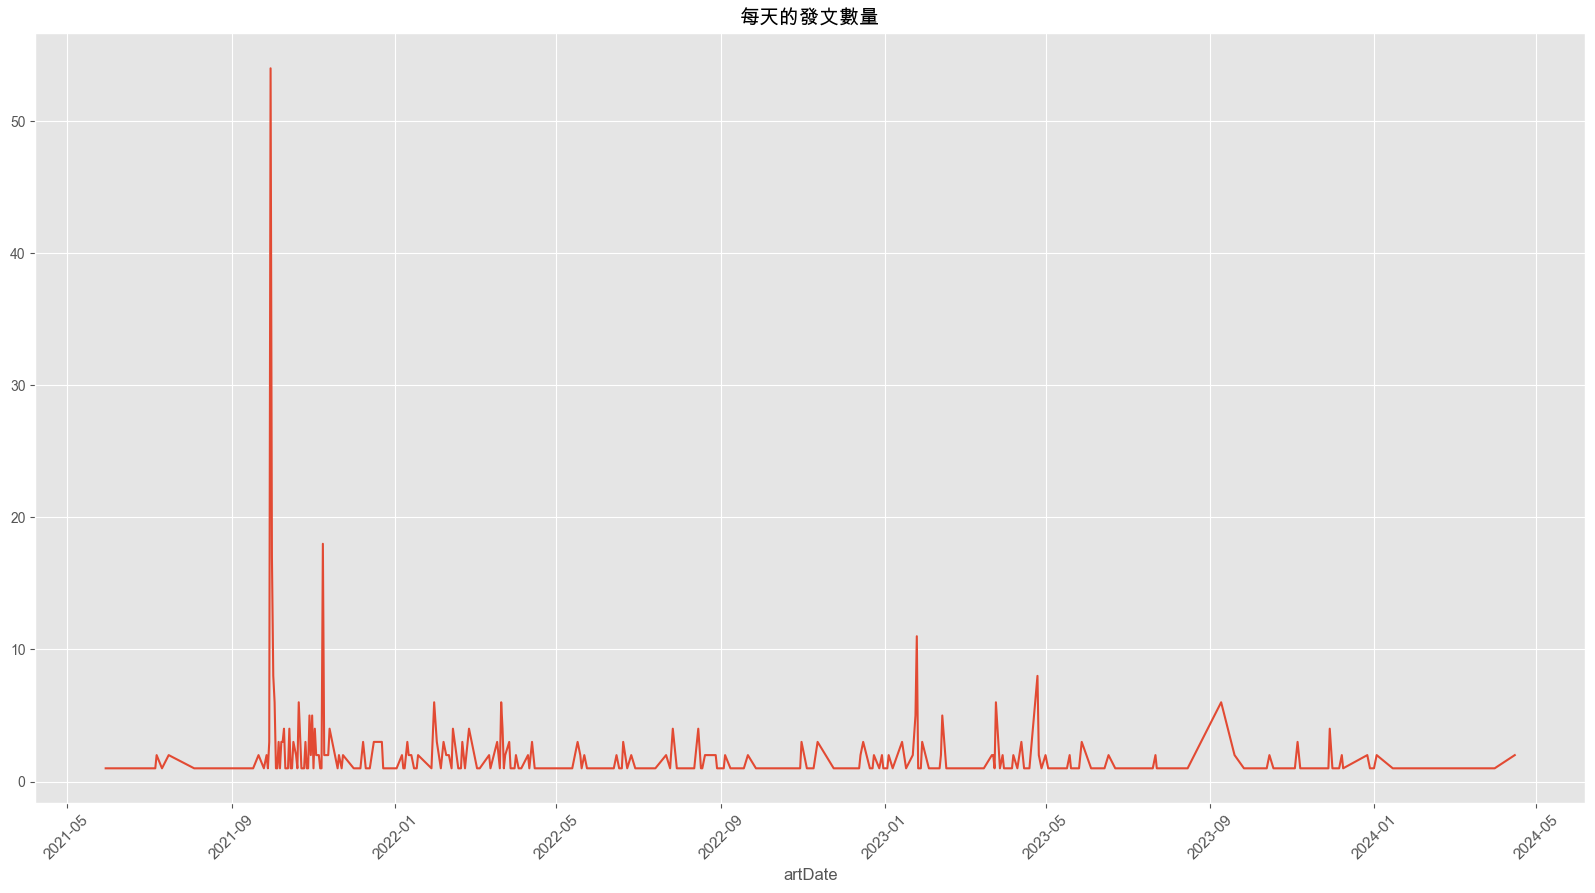

In [20]:
data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count'])

plt.figure(figsize=(20,10))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.title('每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(data_datecount.index,data_datecount['count'].tolist())

*   可看出發文數量較高的時間為2021年九月左右，我們推斷跟疫情有關，失業率上升，年輕人找不到工作看不到未來

### 2.1 正負向情緒及聲量分數折線圖

In [21]:
# 設定整份圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

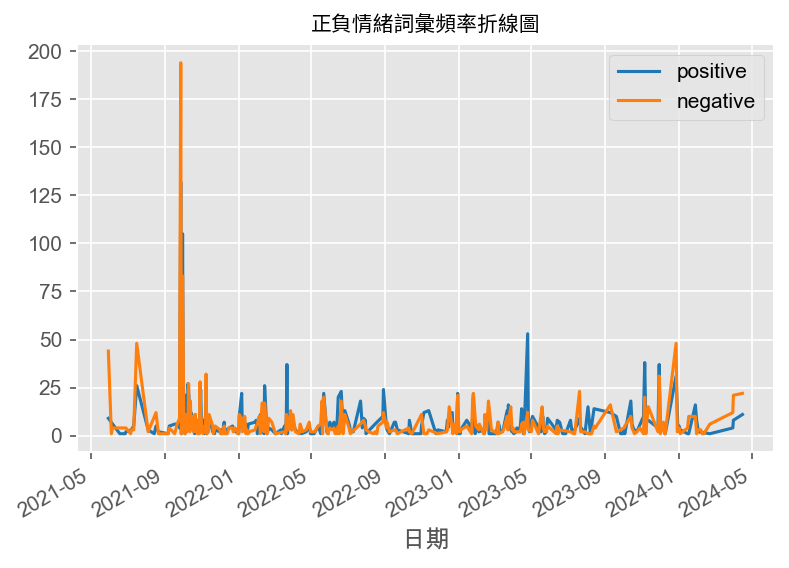

In [22]:
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使 matplotilb 中文能正常顯示
fprop = fm.FontProperties(fname="raw_data/SourceHanSansTW-Regular.otf")

colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("日期")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 顯示中文
plt.show()

*   2021-09~ 2022-01這段期間，負向的情緒分數略高
*   其餘時間，正負向分數接近重疊狀態



- 根據媒體報導「躺平」一詞於 2011 年首次出現在「百度貼吧」的「反婚吧」專欄中。
- 2021 年 4 月 17 日，大陸網路論壇「百度貼吧」一個題為「躺平即是正義」之貼文內容引發關注！
- 「躺平」一詞也漸漸傳到台灣來！逐漸興起討論！

### 2.2 正負向情緒分數比例折線圖圖

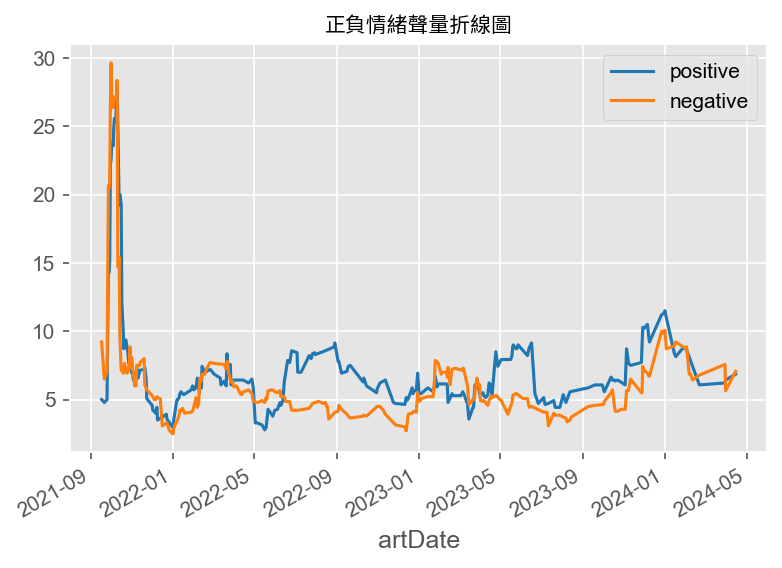

In [23]:
# moving average

colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

*   由折線圖更明顯看出，2021-09~ 2022-01這段期間，負向分數飆高

### 2.3 正負向情緒代表字

In [24]:
word_count =ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
327,問題,affect,212
328,問題,negative,212
517,希望,affect,79
518,希望,positive,79
170,八卦,negative,72
...,...,...,...
392,外向,positive,1
391,外向,affect,1
1063,無視,affect,1
1064,無視,negative,1


In [25]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

,word,sentiments,size
518,希望,positive,79
904,朋友,positive,68
1574,願意,positive,54
1244,簡單,positive,44
1474,輕鬆,positive,38
902,有錢,positive,38
1497,遊戲,positive,36
1520,重要,positive,35
178,分享,positive,34
1328,自由,positive,34


In [26]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

,word,sentiments,size
328,問題,negative,212
170,八卦,negative,72
385,壓力,negative,71
857,放棄,negative,64
1444,負擔,negative,40
358,嚴重,negative,40
825,擔心,negative,39
242,反對,negative,32
772,抱怨,negative,27
724,戰爭,negative,25


/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_20383/3146652837.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_20383/3146652837.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

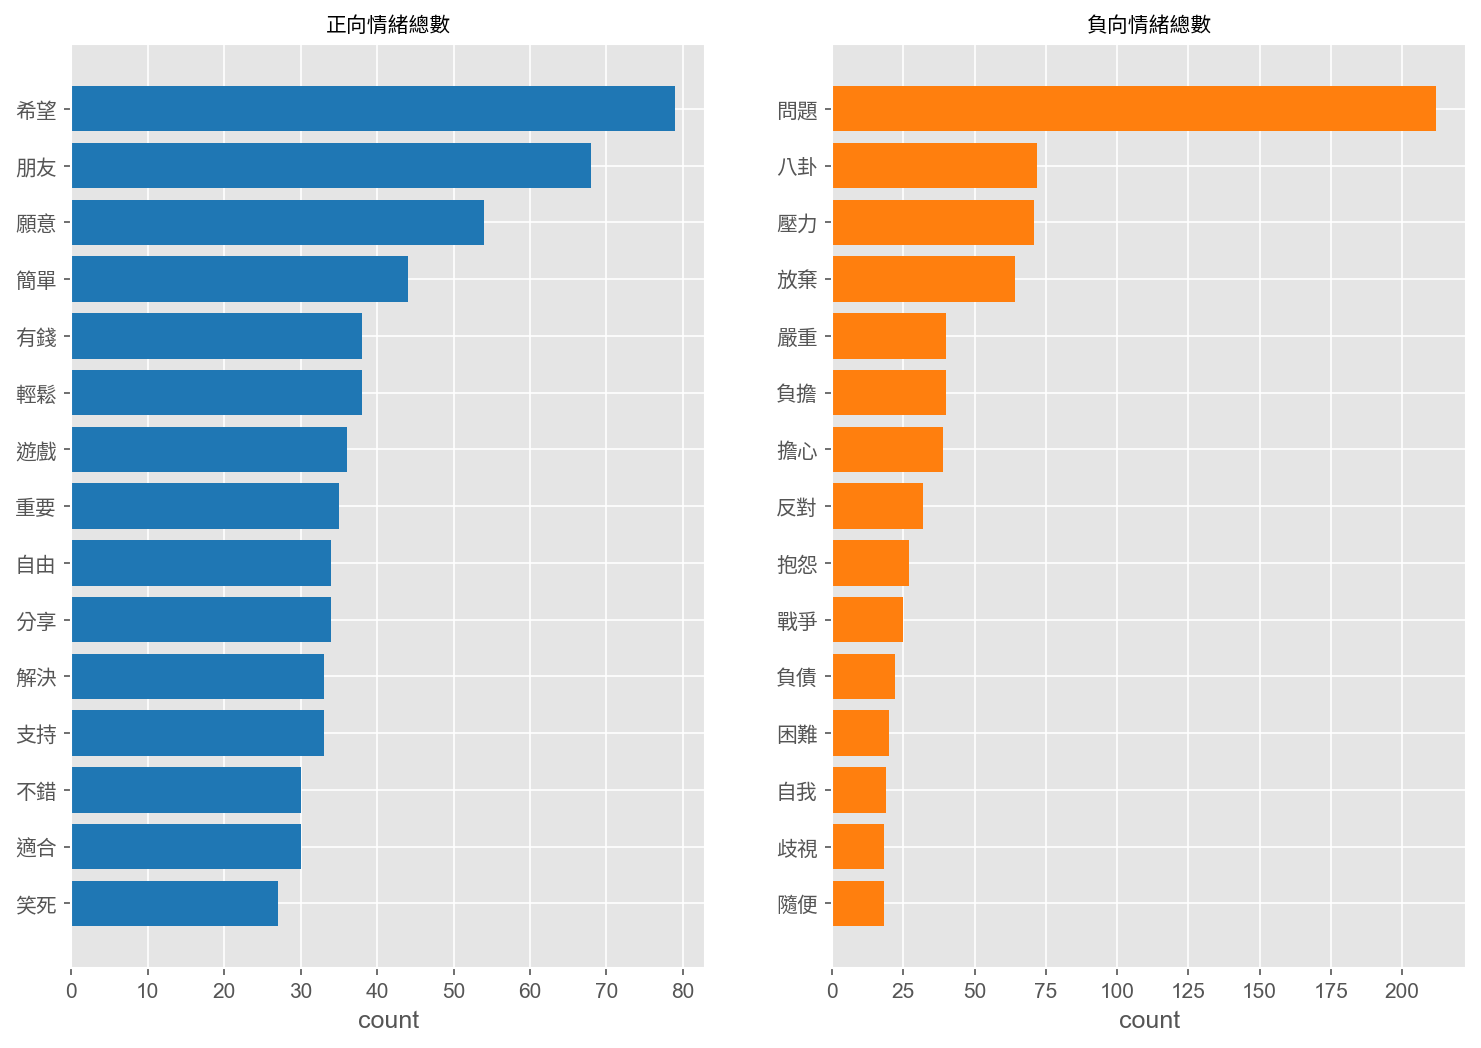

In [27]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2,figsize=(12, 8))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

In [28]:
# 設定要移除的字詞列表
words_to_remove = ['朋友','願意','解決','支持','自由','自我','問題','隨便']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03,[閒聊]沒有工作的一年~~,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,第集,NaN
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03,[閒聊]沒有工作的一年~~,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,沒人開,NaN
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03,[閒聊]沒有工作的一年~~,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,這一,NaN
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03,[閒聊]沒有工作的一年~~,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,閒聊,NaN
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,2022-05-03,[閒聊]沒有工作的一年~~,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,一部,NaN


重新計算情緒

/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_20383/1054577046.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_20383/1054577046.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

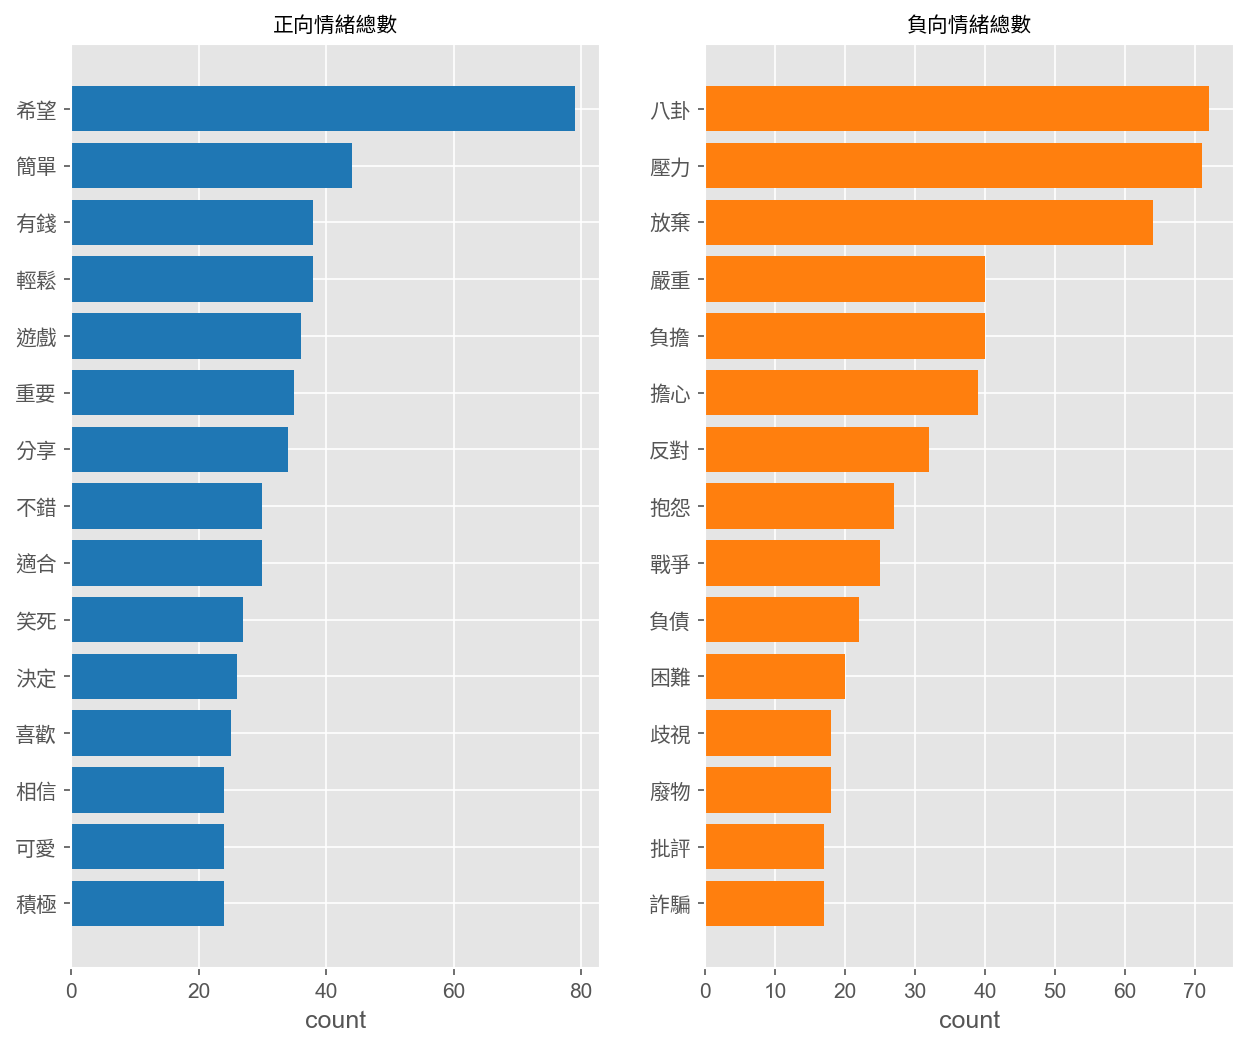

In [29]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2,figsize=(10, 8))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

*    在負向情緒總數的排行中，壓力的詞佔了第二名，我們推測應為房價不斷上漲造成現在年輕人壓力山大想要躺平

### 2.4 文字雲
*    針對討論度最高的一天來畫出該天的文字雲，為2021/09這天。
*    如果文字雲中的字詞大小越大，代表出現頻率越高。

In [30]:
ptt_liwc_df_revise["sentiments"].value_counts()

sentiments
affect      3615
positive    1708
negative    1628
anger        484
anx          306
sad          291
Name: count, dtype: int64

In [31]:
date = "2021-09-01"
end_date = "2022-01-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
   ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date())
   
ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word", "sentiments"]]

### 2021-09-01文字雲

(-0.5, 1599.5, 799.5, -0.5)

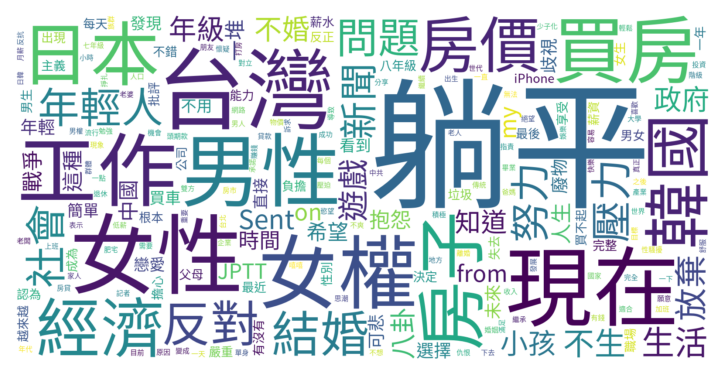

In [32]:
#繪製文字雲
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(50)

# wordcloud 的 input 是 dictionary
font_path = "raw_data/SourceHanSansTW-Regular.otf" # 中文字型路徑
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(6, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")

*   透過文字雲，可看出鄉民常討論的主題包含躺平、買房、房價、結婚...等

## 3. CKIP


### 3.1 CKIP安裝

In [ ]:
data_utils.download_data_gdown("./") # gdrive-ckip # 下載ckip model

Downloading...
From: https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
To: /content/data.zip
100%|██████████| 1.88G/1.88G [00:17<00:00, 107MB/s]


In [35]:
# To use CPU:
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
2024-04-23 20:39:36.500186: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ckiptagger/model_ner.py:57: UserWarning: `tf.nn

### 3.2 使用CKIP進行自然語言處理

In [33]:
## 讀取文章
df = pd.read_csv('raw_data/Lie-Flat.csv')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,[心得]沒有工作的一年,2023-11-03 14:04:20,sgc056613,China_Drama,因為在FB滑到[沒有工作的一年]給打工人的15大金句\n才開始注意到這部陸劇[沒有工作的一年...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kirenenko"", ...",27.240.162.237,2023-11-04 01:06:31,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30 11:12:41,vikk33,Gossiping,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n新唐人\n\n2.記者署名:\n羅...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Imotucc"", ""c...",118.160.146.219,2021-05-31 01:48:03,ptt


定義文字清理的相關function

In [36]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [38]:
# 自定義辭典
with open('./dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[]


In [39]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'],sentence])            
            temp_tokens = get_pos(row['system_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [ ]:
# pos_table, entity_table, sentence_table = get_nlp_result(df)

### 3.3 探索分析-NER

In [41]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("./zh/pos_table.csv") 
entity_table = pd.read_csv("./zh/entity_table.csv") 
sentence_table = pd.read_csv("./zh/sentence_table.csv") 

In [42]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(8)
ner_count

,ner,count
4,GPE,1290
13,PERSON,848
1,DATE,673
0,CARDINAL,638
11,ORG,453
9,NORP,349
7,LOC,110
8,MONEY,106


/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_20383/1254259735.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


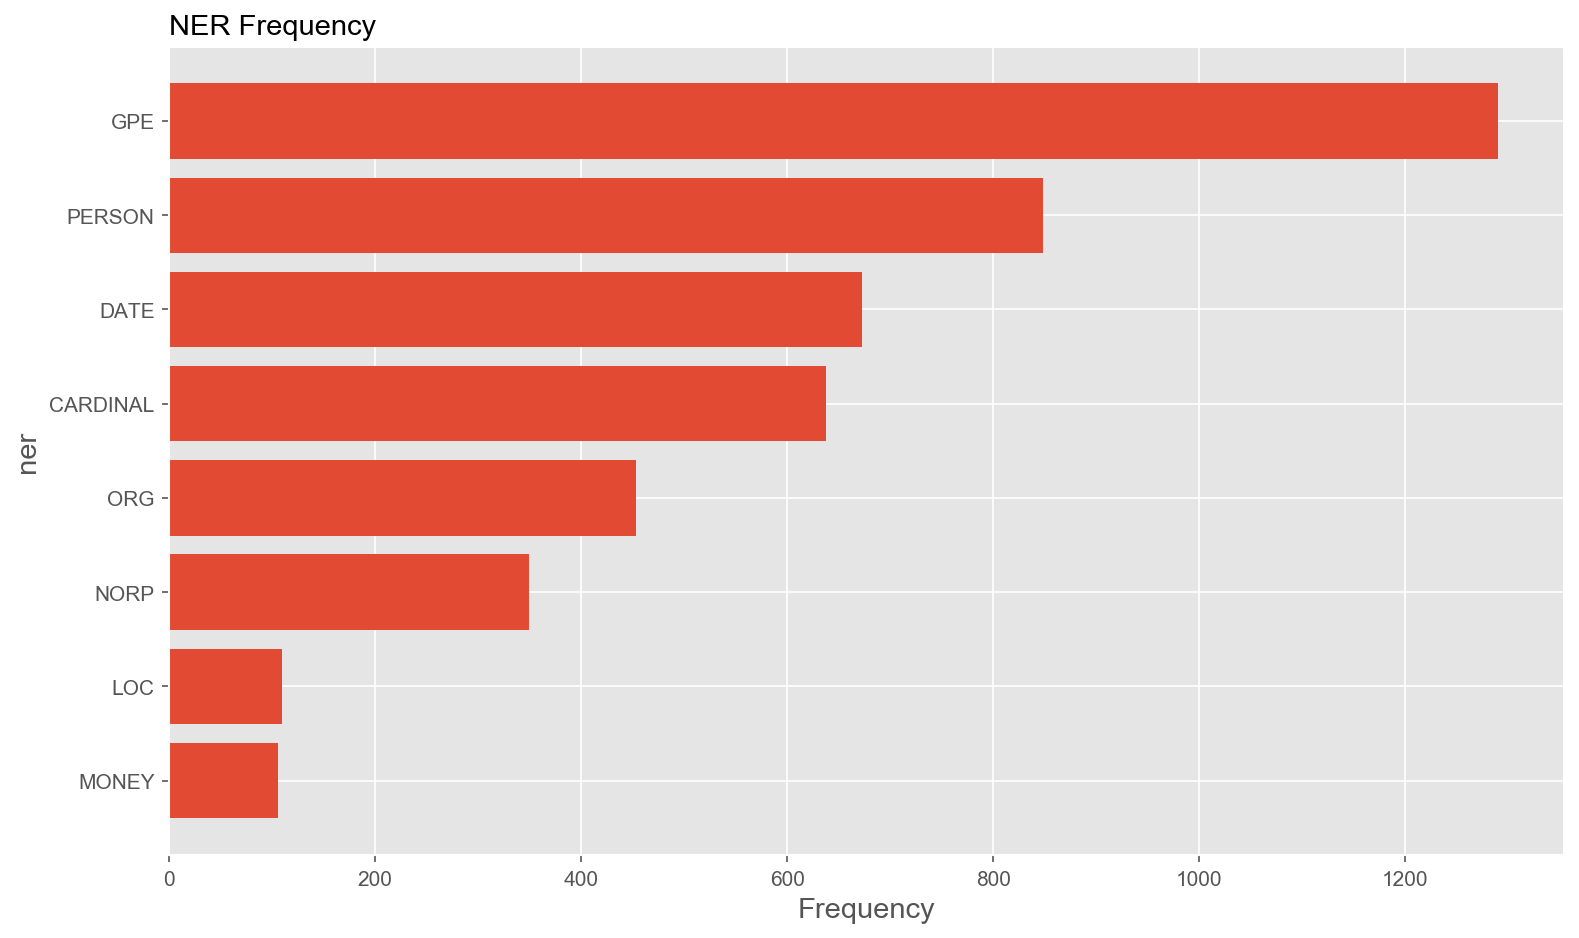

In [43]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

*    資料集中的NER frequency以GPE為最多，推測是因為資料中大量出現「台灣」的詞

### 涉及到的人名(PERSON)

/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_20383/2202349925.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


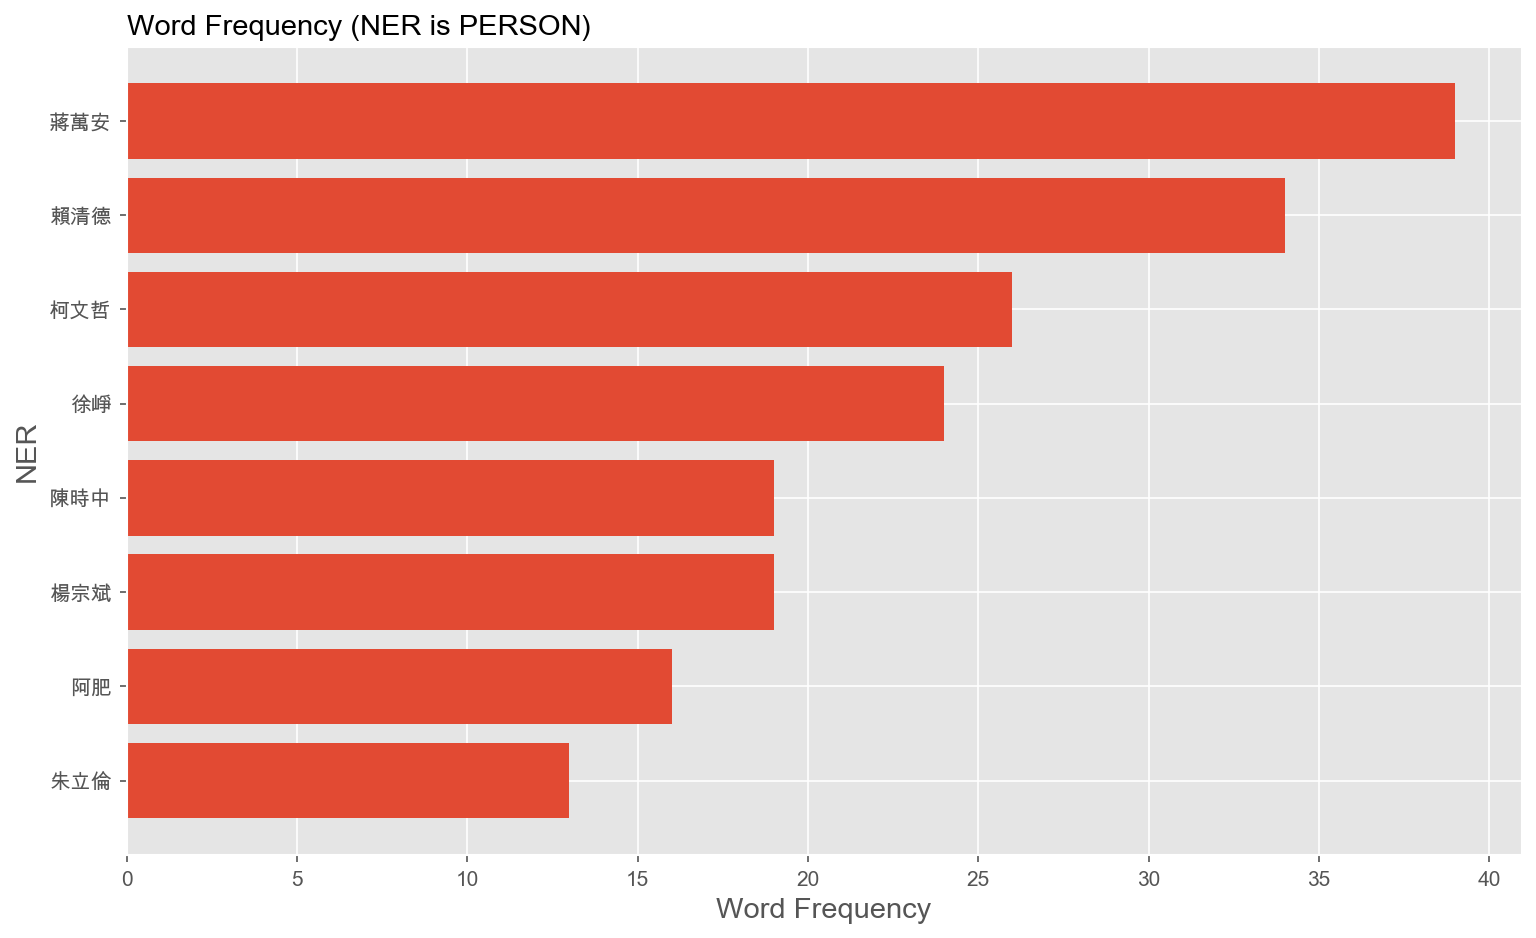

In [45]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

*    在NER的person中的前十名大部分為我國的政治人物

### 涉及到的組織(ORG)

/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_20383/51504683.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


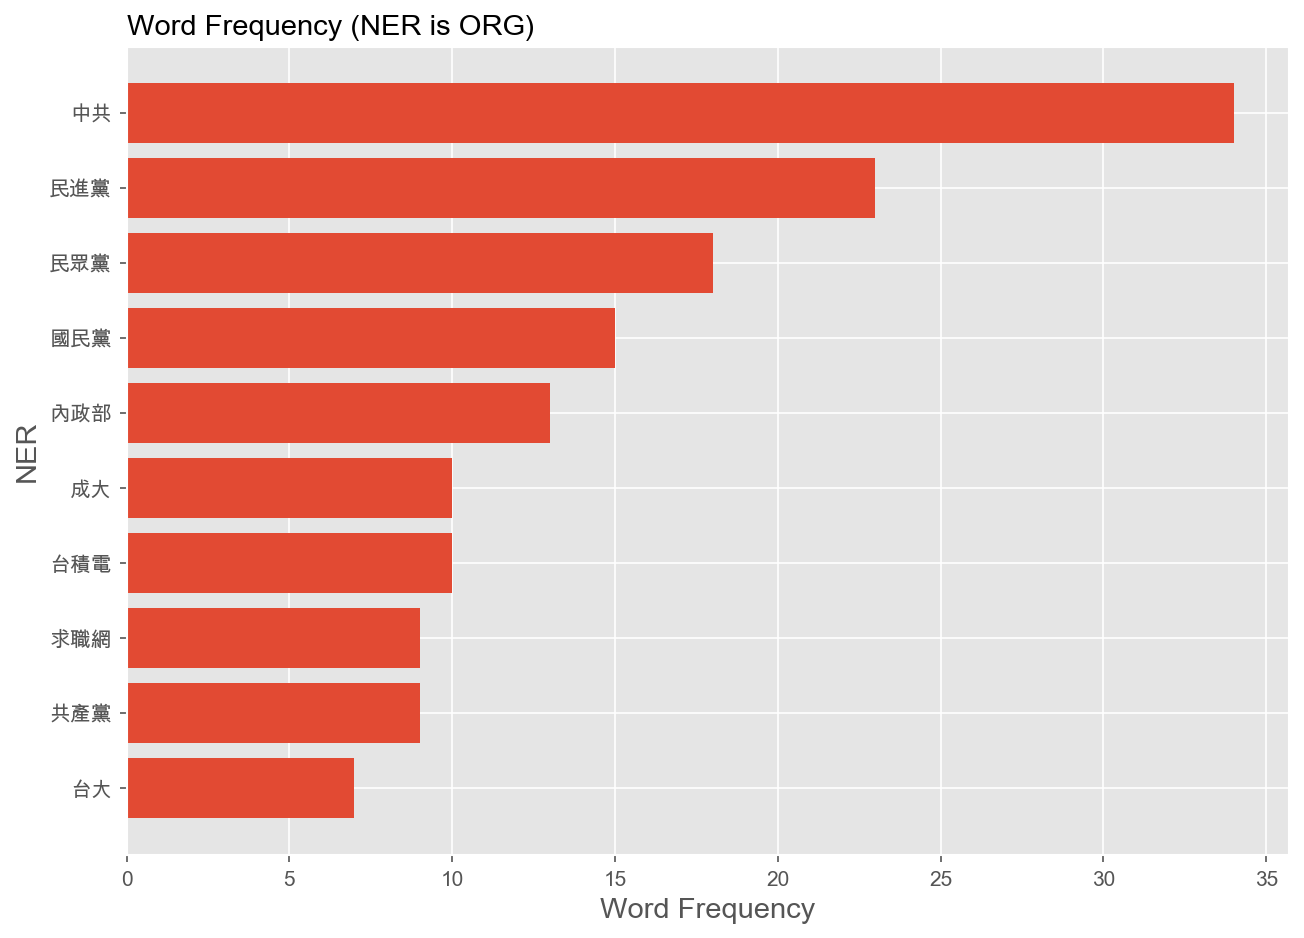

In [46]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的民族、宗教、政治團體(NORP)

/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_20383/1004358742.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


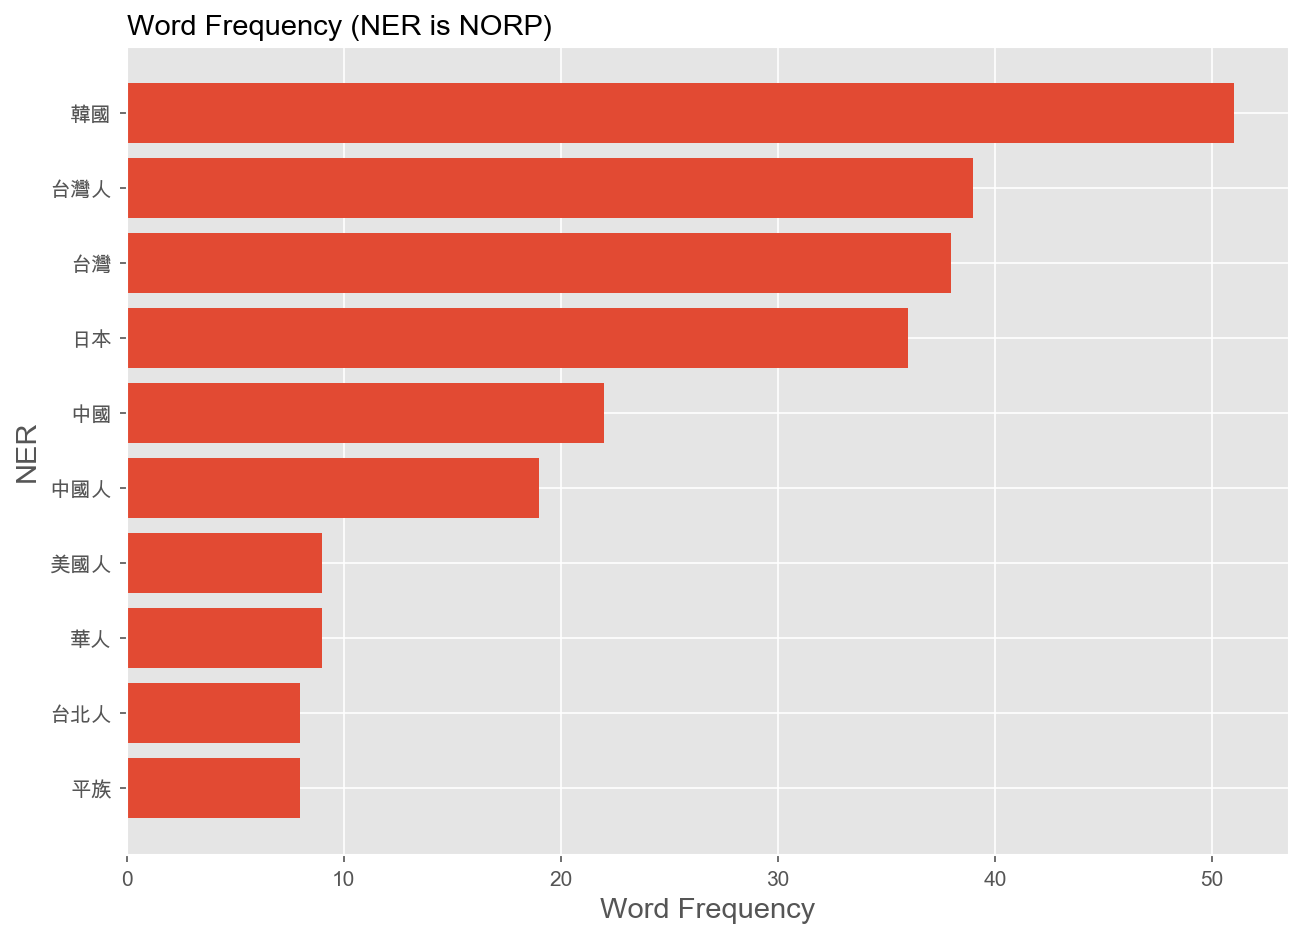

In [47]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 3.4 探索分析-POS

In [48]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
15,Na,23497
5,D,14013
35,VC,8229
41,VH,8014
6,DE,4576
32,VA,3522
17,Nc,3520
29,P,3506
27,Nh,3391
38,VE,2769


/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_20383/2478466374.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


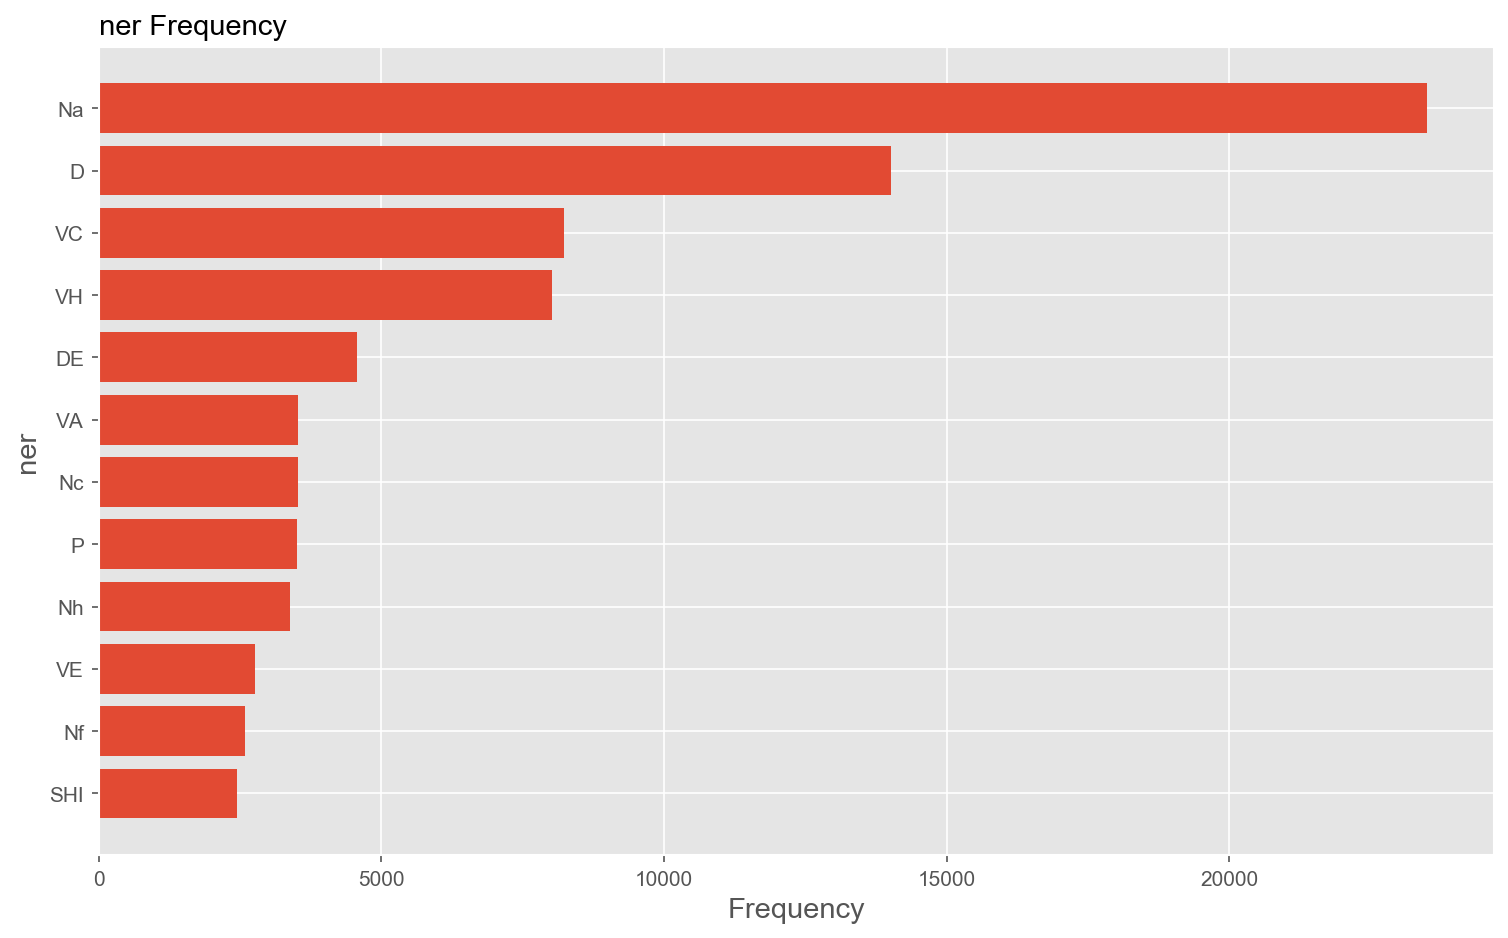

In [49]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的名詞(Noun)

/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_20383/1848481599.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


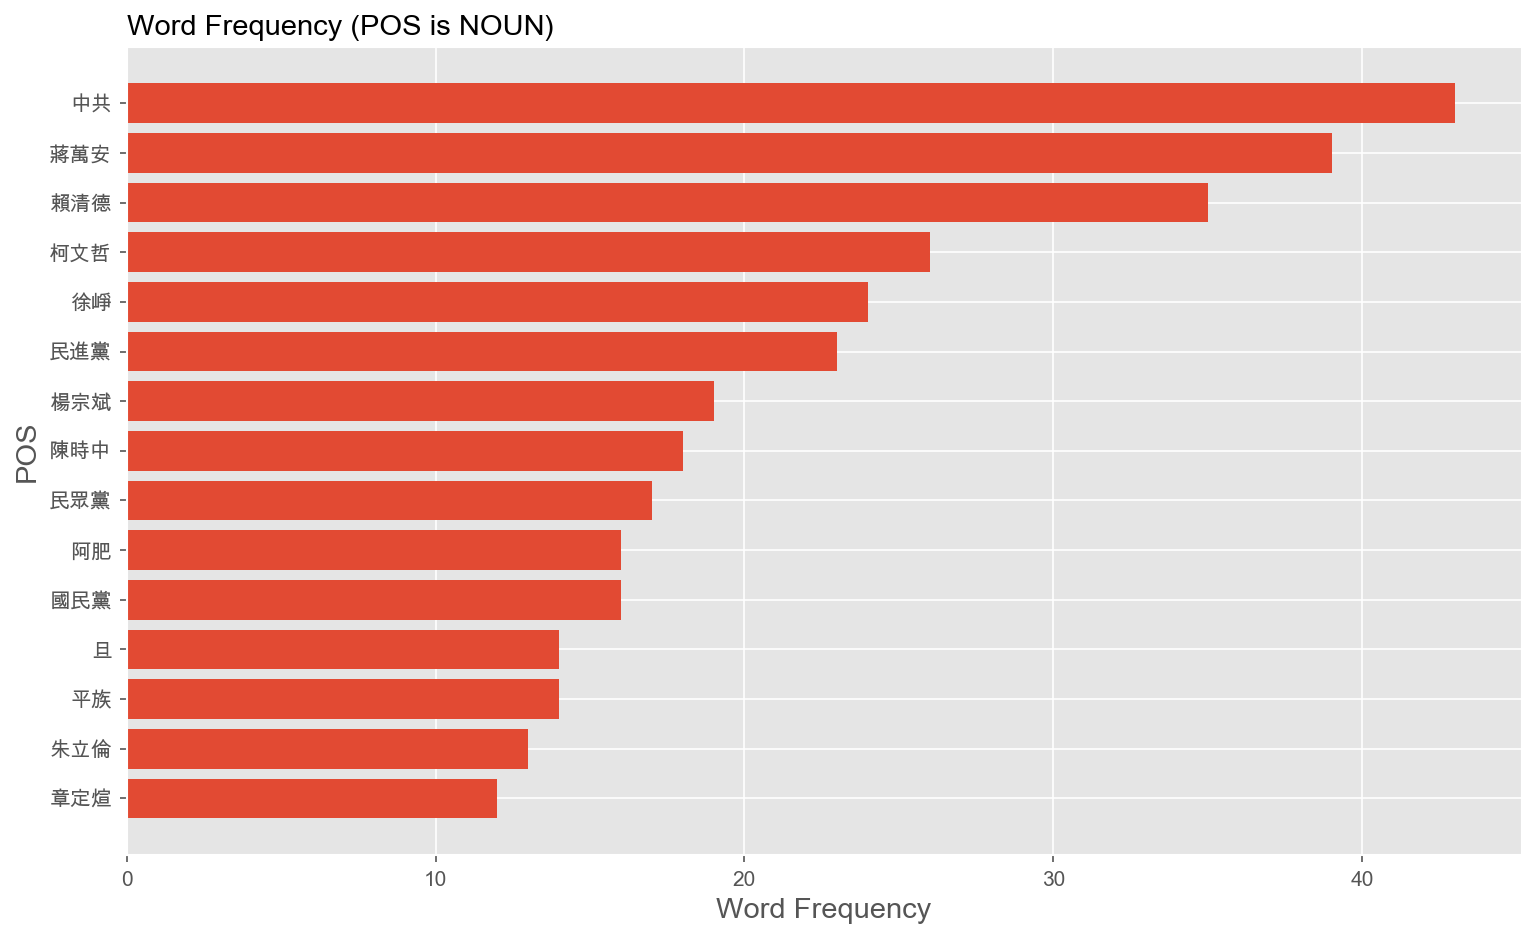

In [50]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)

# 設定中文字形
#plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的動詞(VERB)

/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_20383/4029434985.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


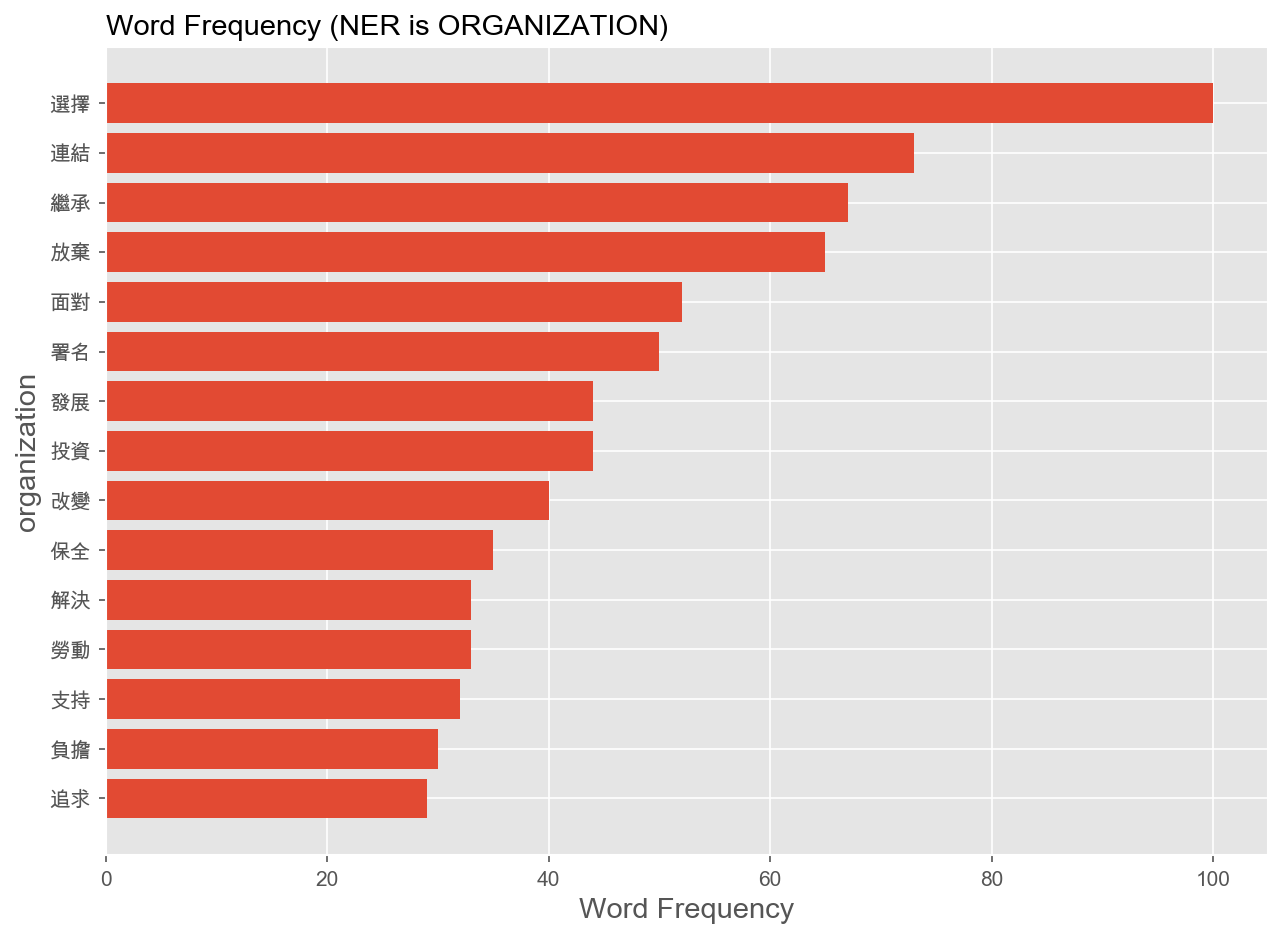

In [51]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)

word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [52]:
keyword_list = ['躺平']
price_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{price_selected.shape[0]}篇相關貼文")
price_selected.head(3)

躺平：548篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,[心得]沒有工作的一年,2023-11-03 14:04:20,sgc056613,China_Drama,因為在FB滑到[沒有工作的一年]給打工人的15大金句\n才開始注意到這部陸劇[沒有工作的一年...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kirenenko"", ...",27.240.162.237,2023-11-04 01:06:31,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30 11:12:41,vikk33,Gossiping,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n新唐人\n\n2.記者署名:\n羅...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Imotucc"", ""c...",118.160.146.219,2021-05-31 01:48:03,ptt


## 4. 利用SnowNLP進行情緒分析

In [53]:
from snownlp import SnowNLP
sentence_table = pd.read_csv("./zh/sentence_table.csv") 

sentiment_date = pd.merge(sentence_table,price_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head()

Exception ignored in: <function WS.__del__ at 0x13e89c680>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ckiptagger/api.py", line 65, in __del__
    self.model.sess.close()
    ^^^^^^^^^^
AttributeError: 'WS' object has no attribute 'model'


,system_id,sentence,artDate,dataSource
0,1,都第集了，,2022-05-03 19:54:49,ptt
1,1,竟然沒人開這檔閒聊，,2022-05-03 19:54:49,ptt
2,1,這是部顛覆的都市情感劇，,2022-05-03 19:54:49,ptt
3,1,沒有白富美的女，,2022-05-03 19:54:49,ptt
4,1,也沒有高富帥的男，,2022-05-03 19:54:49,ptt


In [54]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head()

,system_id,sentence,artDate,dataSource,sentimentValue
0,1,都第集了，,2022-05-03 19:54:49,ptt,0.525113
1,1,竟然沒人開這檔閒聊，,2022-05-03 19:54:49,ptt,0.125853
2,1,這是部顛覆的都市情感劇，,2022-05-03 19:54:49,ptt,0.996822
3,1,沒有白富美的女，,2022-05-03 19:54:49,ptt,0.764614
4,1,也沒有高富帥的男，,2022-05-03 19:54:49,ptt,0.588317


<Axes: >

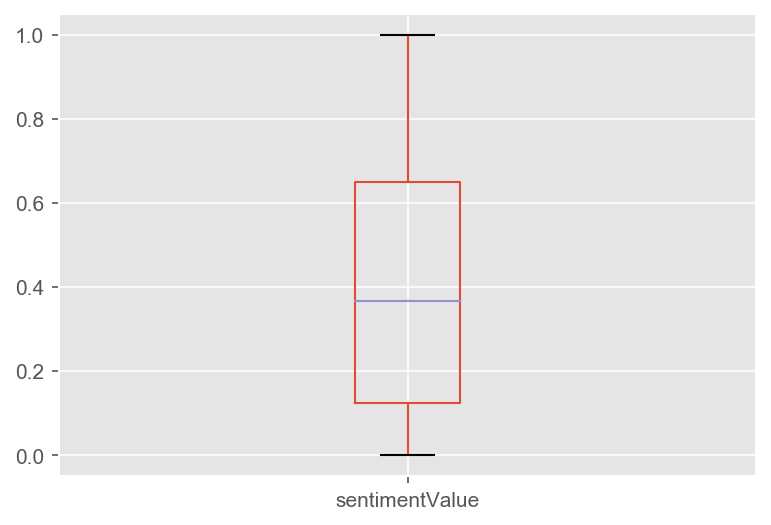

In [55]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

In [56]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count.head()

,artDate,sentimentValue
0,2021-05,0.305226
1,2021-06,0.426624
2,2021-07,0.447891
3,2021-08,0.520418
4,2021-09,0.449532


/var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/ipykernel_20383/3287014777.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


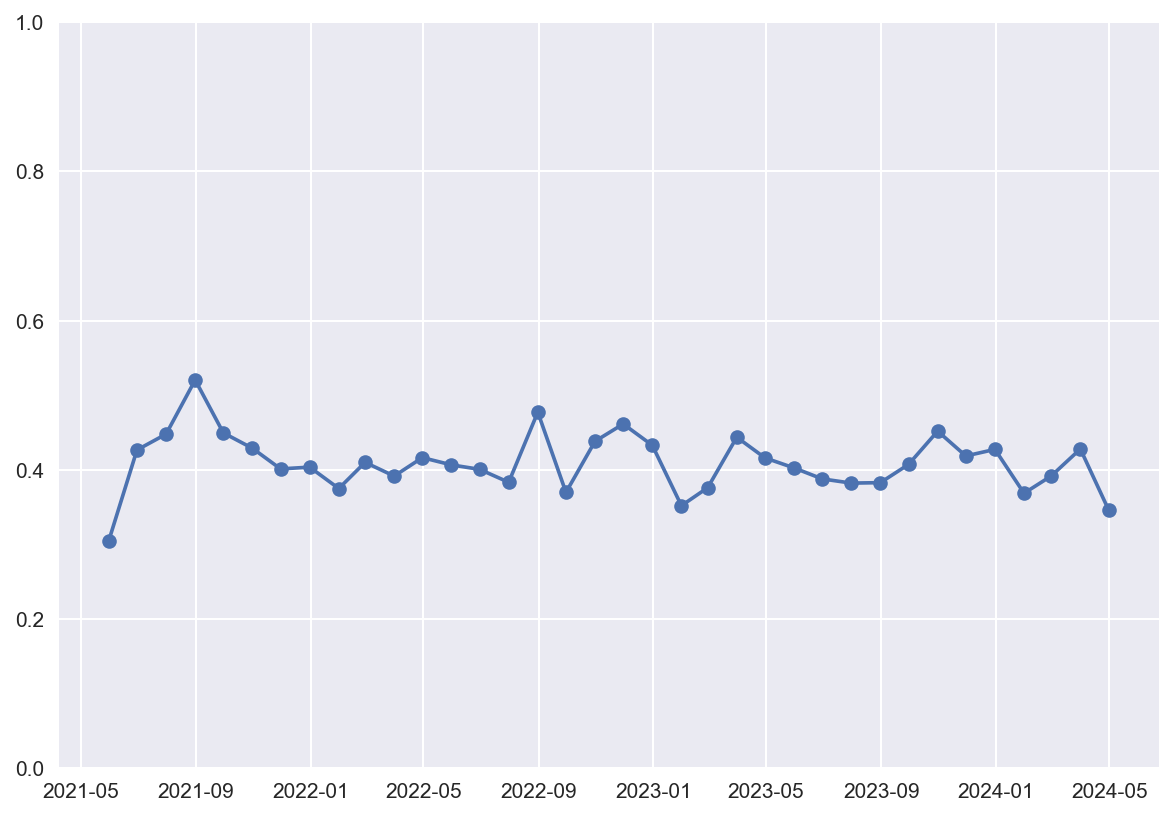

In [57]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

## 5. TF-IDF
### 5.1 計算每個詞彙的TF-IDF
TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
- **TF** (Term Frequency)：某一個詞彙在某一個文件中所出現的頻率  
    - TF = 詞彙在該文件中出現次數 / 該文件中詞彙總數  
- **IDF** (Inverse Document Frequent)：為文件數除以某特定詞彙有被多少文件所提及的數量取log  
    - IDF = log( 總文件數量 / 包含該詞彙的文件數量 ) 



In [61]:
# 每篇文章的總詞彙數
MetaData = df.copy()
MetaData.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,[心得]沒有工作的一年,2023-11-03 14:04:20,sgc056613,China_Drama,因為在FB滑到[沒有工作的一年]給打工人的15大金句\n才開始注意到這部陸劇[沒有工作的一年...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kirenenko"", ...",27.240.162.237,2023-11-04 01:06:31,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30 11:12:41,vikk33,Gossiping,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n新唐人\n\n2.記者署名:\n羅...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Imotucc"", ""c...",118.160.146.219,2021-05-31 01:48:03,ptt
3,4,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,[問卦]我就爛有另一種說法嗎?,2021-06-04 20:36:41,eric112,Gossiping,在日本有草食男或啃老族\n\n現在中國忽然來了一個躺平族\n\n那有沒有其他的說法比較文雅的...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""makinoyui"", ...",36.227.134.238,2021-06-05 01:20:55,ptt
4,5,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,Re:[問卦]具體來說現在在等什麼,2021-06-06 18:30:04,leondemon,Gossiping,依據人性\n\n1. 人是自私的，自己的利益優先考量\n2. 別人的不幸甜如蜜\n\n但是大...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""jjjjjjs"", ""c...",27.53.17.75,2021-06-07 01:25:44,ptt


In [62]:
# 移除網址格式
MetaData['sentence'] = MetaData.artContent.apply(lambda x: re.sub('(http|https)://.*', '', str(x)))
# 只留下中文字
MetaData['sentence'] = MetaData.artContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',str(x)))
MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...
1,2,https://www.ptt.cc/bbs/China-Drama/M.169899146...,[心得]沒有工作的一年,2023-11-03 14:04:20,sgc056613,China_Drama,因為在FB滑到[沒有工作的一年]給打工人的15大金句\n才開始注意到這部陸劇[沒有工作的一年...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kirenenko"", ...",27.240.162.237,2023-11-04 01:06:31,ptt,因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年總共也才集本來只是...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30 11:12:41,vikk33,Gossiping,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n新唐人\n\n2.記者署名:\n羅...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Imotucc"", ""c...",118.160.146.219,2021-05-31 01:48:03,ptt,備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷完整新聞標題中國人躺平火爆網路當局...


In [64]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt')

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [65]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [66]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

# 將word欄位展開
data = data.explode('word')

data.head(3)

Building prefix dict from /Users/wuanjie/Desktop/NLP/mid-project/dict/dict.txt ...
Loading model from cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.u9bb5604f6615f74065eb106a934eec11.cache
Loading model cost 1.705 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,第集
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,沒人開
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,這一


In [67]:
# 每篇文章的總詞彙數
total_words = data.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,43
1,https://www.ptt.cc/bbs/China-Drama/M.169899146...,106
2,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,749
3,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,11
4,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,42
...,...,...
620,https://www.ptt.cc/bbs/job/M.1641443264.A.EF6....,256
621,https://www.ptt.cc/bbs/prozac/M.1632232347.A.6...,106
622,https://www.ptt.cc/bbs/prozac/M.1667170649.A.7...,104
623,https://www.ptt.cc/bbs/prozac/M.1667221824.A.6...,40


In [68]:
# 計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

,artUrl,word,count
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一種,1
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1
...,...,...,...
39561,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,資料,1
39562,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,躺平,1
39563,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,預訂,1
39564,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,體力,1


In [69]:
lie_flat_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
lie_flat_words

,artUrl,word,count,total
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一種,1,43
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1,43
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1,43
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1,43
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1,43
...,...,...,...,...
39561,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,資料,1,29
39562,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,躺平,1,29
39563,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,預訂,1,29
39564,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,體力,1,29


計算tf-idf值

In [70]:
# 計算tf
lie_flat_words_tf_idf = lie_flat_words.assign(tf = lie_flat_words.iloc[:,2]/lie_flat_words.iloc[:,3])
lie_flat_words_tf_idf.head()

,artUrl,word,count,total,tf
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一種,1,43,0.023256
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1,43,0.023256
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1,43,0.023256
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1,43,0.023256
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1,43,0.023256


In [72]:
# 計算每個詞彙出現在幾篇文章中
idf_df = lie_flat_words.groupby(['word'],as_index=False).size()
lie_flat_words_tf_idf = lie_flat_words_tf_idf.merge(idf_df,on = 'word',how = 'left')
lie_flat_words_tf_idf.head()

,artUrl,word,count,total,tf,size
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一種,1,43,0.023256,27
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1,43,0.023256,1
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1,43,0.023256,80
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1,43,0.023256,35
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1,43,0.023256,1


In [73]:
# 計算idf
lie_flat_words_tf_idf = lie_flat_words_tf_idf.assign(idf = lie_flat_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

lie_flat_words_tf_idf = lie_flat_words_tf_idf.drop(labels=['size'],axis=1)
lie_flat_words_tf_idf.head()

,artUrl,word,count,total,tf,idf
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一種,1,43,0.023256,1.364516
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1,43,0.023256,2.795880
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1,43,0.023256,0.892790
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1,43,0.023256,1.251812
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1,43,0.023256,2.795880


In [74]:
# 計算tf*idf
lie_flat_words_tf_idf = lie_flat_words_tf_idf.assign(tf_idf = lie_flat_words_tf_idf.iloc[:,4] * lie_flat_words_tf_idf.iloc[:,5])
lie_flat_words_tf_idf.head()

,artUrl,word,count,total,tf,idf,tf_idf
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一種,1,43,0.023256,1.364516,0.031733
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1,43,0.023256,2.795880,0.065020
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1,43,0.023256,0.892790,0.020763
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1,43,0.023256,1.251812,0.029112
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1,43,0.023256,2.795880,0.065020


In [75]:
# 選出每篇文章，tf-idf值最大的前五個詞
group = lie_flat_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))
group

artUrl  \
artUrl                                                                                                        
https://www.ptt.cc/bbs/China-Drama/M.1651578891... 1      https://www.ptt.cc/bbs/China-Drama/M.165157889...   
                                                   4      https://www.ptt.cc/bbs/China-Drama/M.165157889...   
                                                   5      https://www.ptt.cc/bbs/China-Drama/M.165157889...   
                                                   8      https://www.ptt.cc/bbs/China-Drama/M.165157889...   
                                                   9      https://www.ptt.cc/bbs/China-Drama/M.165157889...   
...                                                                                                     ...   
https://www.ptt.cc/bbs/prozac/M.1676291646.A.CA... 39542  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   
                                                   39544  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   
                                                   39548  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   
                                                   39549  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   
                                                   39557  https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...   

                                                         word  count  total  \
artUrl                                                                        
https://www.ptt.cc/bbs/China-Drama/M.1651578891... 1       一部      1     43   
                                                   4       候選      1     43   
                                                   5       劇王      1     43   
                                                   8       受挫      1     43   
                                                   9       大雨      1     43   
...                                                       ...    ...    ...   
https://www.ptt.cc/bbs/prozac/M.1676291646.A.CA... 39542   厭煩      1     29   
                                                   39544   很花      1     29   
                                                   39548   憂鬱      1     29   
                                                   39549  憂鬱症      1     29   
                                                   39557  精神力      1     29   

                                                                tf      idf  \
artUrl                                                                        
https://www.ptt.cc/bbs/China-Drama/M.1651578891... 1      0.023256  2.79588   
                                                   4      0.023256  2.79588   
                                                   5      0.023256  2.79588   
                                                   8      0.023256  2.79588   
                                                   9      0.023256  2.79588   
...                                                            ...      ...   
https://www.ptt.cc/bbs/prozac/M.1676291646.A.CA... 39542  0.034483  2.79588   
                                                   39544  0.034483  2.79588   
                                                   39548  0.034483  2.79588   
                                                   39549  0.034483  2.79588   
                                                   39557  0.034483  2.79588   

                                                           tf_idf  
artUrl                                                             
https://www.ptt.cc/bbs/China-Drama/M.1651578891... 1      0.06502  
                                                   4      0.06502  
                                                   5      0.06502  
                                                   8      0.06502  
                                                   9      0.06502  
...                                                           ...  
https://www.ptt.cc/bbs/prozac/M.1676291646.A.CA... 39542 

In [76]:
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
artUrl                                                               
https://www.ptt.cc/bbs/China-Drama/M.1651578891... 1     一部  0.065020
                                                   4     候選  0.065020
                                                   5     劇王  0.065020
                                                   8     受挫  0.065020
                                                   9     大雨  0.065020
https://www.ptt.cc/bbs/China-Drama/M.1698991462... 119   金句  0.052752
                                                   50    人生  0.050535
                                                   71    愛情  0.043750
                                                   104   職場  0.039564
                                                   98    答案  0.034748
https://www.ptt.cc/bbs/Gossiping/M.1622344364.A... 304   火爆  0.029863
                                                   141   中共  0.028772
                                                   299   消費  0.025767
                                                   145   主義  0.021346
                                                   212   學者  0.018857

### 計算整個文集中較常 tf-idf 值高的字

In [77]:
# 從每篇文章挑選出tf-idf最大的前十個詞
(lie_flat_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
1993,年輕人,14
1986,年級,13
4270,躺平,13
3670,網友,12
1169,台灣,12
802,八年級,12
103,七年級,12
1849,小孩,11
1914,工作,11
310,中國,11


## 6.透過結巴斷詞與N-gram幫助建立字典

### 6.1 Bigram

In [78]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [81]:
lie_flat_bigram = MetaData.copy()

lie_flat_bigram["word"] =lie_flat_bigram.sentence.apply(bigram_getToken)
lie_flat_bigram = lie_flat_bigram.explode('word')
lie_flat_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,第集 沒人開
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,沒人開 這一
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,這一 閒聊


#### 統計最常出現的bigram組合

In [83]:
# 計算每個組合出現的次數
lie_flat_bigram_count = lie_flat_bigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的bigram組合
fb_filter = list(lie_flat_bigram_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
lie_flat_bigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
13544,完整 新聞,148
1756,不婚 不生,76
20402,推錢 推錢,54
21862,新聞 標題,52
36077,記者 署名,50
21840,新聞 內文,50
12977,媒體 來源,49
21880,新聞 連結,48
40352,連結 網址,43
42883,青年 勞工,40


### 6.2 Trigram

In [84]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [85]:
lie_flat_trigram = MetaData.copy()

lie_flat_trigram["word"] = lie_flat_trigram.sentence.apply(trigram_getToken)
lie_flat_trigram = lie_flat_trigram.explode('word')
lie_flat_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,第集 沒人開 這一
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,沒人開 這一 閒聊
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,這一 閒聊 一部


#### 統計最常出現的trigram組合

In [86]:
# 計算每個組合出現的次數
lie_flat_trigram_count = lie_flat_trigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的trigram組合
fb_filter = list(lie_flat_trigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
lie_flat_trigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
14645,完整 新聞 標題,50
14644,完整 新聞 內文,50
14646,完整 新聞 連結,48
23864,新聞 連結 網址,43
22164,推錢 推錢 推錢,26
1770,不可 轉載 媒體,24
4994,來源 記者 署名,15
12066,報導 完整 新聞,15
14036,媒體 來源 記者,15
44156,連結 網址 備註,14


### 6.3 使用Ngram建立模型

### Bigram預測模型

In [87]:
data = MetaData.copy()
sen_tokens = data.sentence.apply(getToken).tolist()

In [92]:
from collections import namedtuple, Counter

def ngram(documents, N=2):
    # Ensuring dict is not overridden
    global dict
    dict = __builtins__.dict

    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # Adding start and end tags
        split_words = ['<s>'] + list(doc) + ['</s>']
        # Calculating numerators
        for i in range(len(split_words)-N+1):
            total_grams.append(tuple(split_words[i:i+N]))
        # Calculating denominators
        for i in range(len(split_words)-N+2):
            words.append(tuple(split_words[i:i+N-1]))
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key] / word_counter[key[:N-1]]  # P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [93]:
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

### 預測下一個出現的詞

In [94]:
text = '躺平'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: </s>, probability: 0.0449
next word: 躺平, probability: 0.0261
next word: 主義, probability: 0.0253
next word: 工作, probability: 0.0122
next word: 台灣, probability: 0.0114


In [96]:
text = '年輕人'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 躺平, probability: 0.0367
next word: 買不起, probability: 0.0333
next word: 買房, probability: 0.0233
next word: 工作, probability: 0.0233
next word: 面臨, probability: 0.02


In [97]:
text = '房價'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 飆漲, probability: 0.0379
next word: 物價, probability: 0.0341
next word: 躺平, probability: 0.0227
next word: 速度, probability: 0.0189
next word: 負擔, probability: 0.0189


### 6.4 Bigram視覺化

In [98]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [99]:
lie_flat_bigram2 = MetaData.copy()
lie_flat_bigram2["word"] = lie_flat_bigram2.sentence.apply(bigram_getToken_dict)

In [100]:
lie_flat_bigram2 = lie_flat_bigram2.explode('word')
lie_flat_bigram2.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,第集 沒人開
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,沒人開 這一
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,vincentwjs,China_Drama,都第10集了，\n竟然沒人開這一檔閒聊，\n這是一部顛覆的都市情感劇，\n沒有白富美的女一，...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,這一 閒聊


In [101]:
d = {k:v for k,v in bigramfdist.most_common(50)}

In [102]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

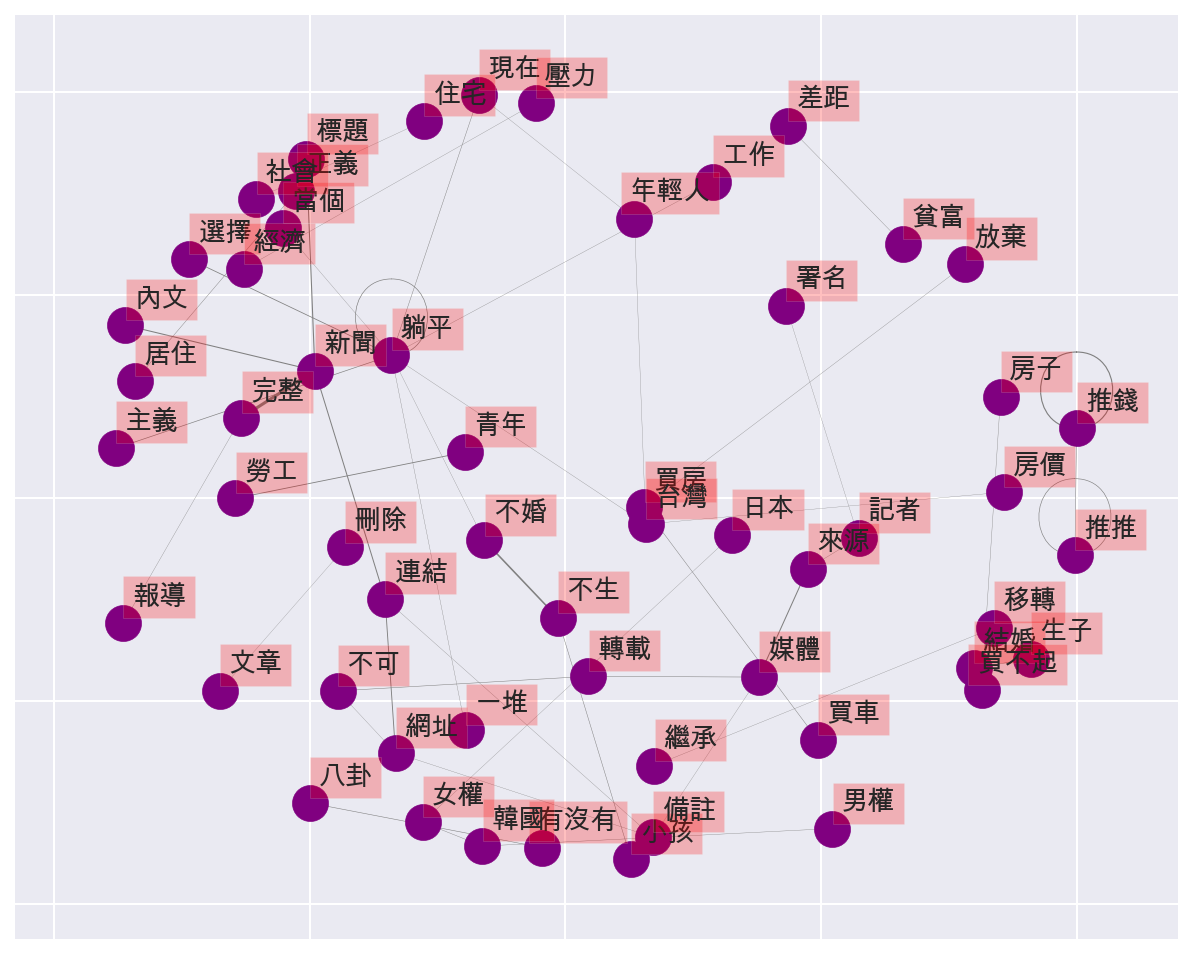

In [104]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

### 6.5 Pairwise correlation
計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)

In [105]:
# 取常一起出現的bigram pair 前1500筆
b = {k:v for k,v in bigramfdist.most_common(1500)}

In [106]:
# 建立DataFrame
bigram_df = pd.DataFrame(list(b), columns=['word','word2']).assign(n=b.values())

In [107]:
# 每個bigram組合的次數
bigram_df.head()

,word,word2,n
0,完整,新聞,148
1,不婚,不生,76
2,推錢,推錢,54
3,新聞,標題,52
4,記者,署名,50


In [108]:
# 再次計算各詞彙在各文章中出現的次數
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)
data = data.explode('word')

word_count2 = data.groupby(['artUrl','word'],as_index=False).size()
word_count2.rename(columns={'size': 'count'}, inplace=True)
word_count2.head(3)

,artUrl,word,count
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一種,1
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1


In [109]:
#計算phi值
def phi_cor(df):
    # total x
    nx = len(set(word_count2[word_count2["word"]==df["word"]]["artUrl"]))
    tnx = len(MetaData)-nx
    # total y
    ny = len(set(word_count2[word_count2["word"]==df["word2"]]["artUrl"]))
    tny = len(MetaData)-ny
    # 有x 有y
    x_ls = list(word_count2[word_count2["word"]==df["word"]]["artUrl"]) #單獨有x
    y_ls = list(word_count2[word_count2["word"]==df["word2"]]["artUrl"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    # 有x 沒有y
    nxo = nx-nxy
    # 沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["artUrl"]))-uxy) #取差集:全-有x有y
    # 沒有x 有y
    noy = ny-nxy
    # print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [110]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [111]:
lie_flat_sum = bigram_df[(bigram_df["word"]=="躺平")].sort_values(by=['cor'], ascending = False).head(10)
young_sum = bigram_df[(bigram_df["word"]=="年輕人")].sort_values(by=['cor'], ascending = False).head(10)

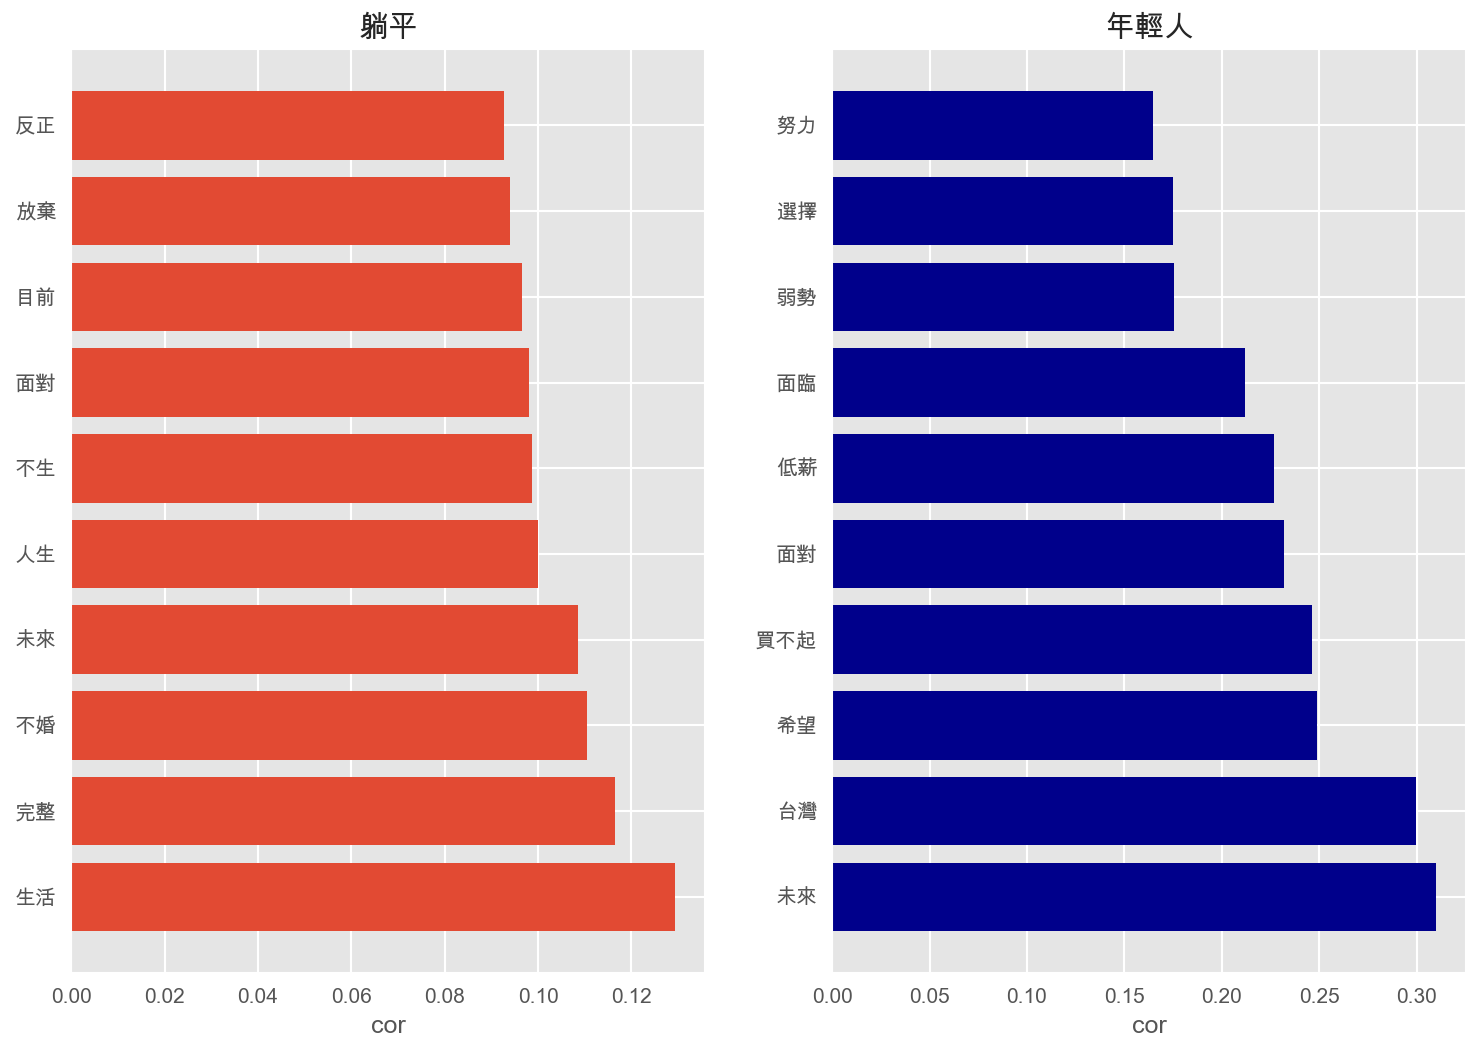

In [113]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('躺平')
plt.xlabel('cor')
plt.barh(lie_flat_sum['word2'],lie_flat_sum['cor'])

plt.subplot(122)
plt.title('年輕人')
plt.xlabel('cor')
plt.barh(young_sum['word2'],young_sum['cor'],color="darkblue")


plt.show()

### 6.7使用詞彙關係圖畫出相關性大於0.4的組合 

In [114]:
bigram_df[bigram_df["cor"]>0.4].head()

,word,word2,n,cor
0,完整,新聞,148,0.707195
1,不婚,不生,76,0.808547
3,新聞,標題,52,0.747767
4,記者,署名,50,0.851002
5,新聞,內文,50,0.733302


In [115]:
word_cors = bigram_df[bigram_df["cor"]>0.4]
word_cors.reset_index(inplace=True, drop=True)

In [116]:
import networkx as nx
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*10 for w in  g.edges(data=True)]

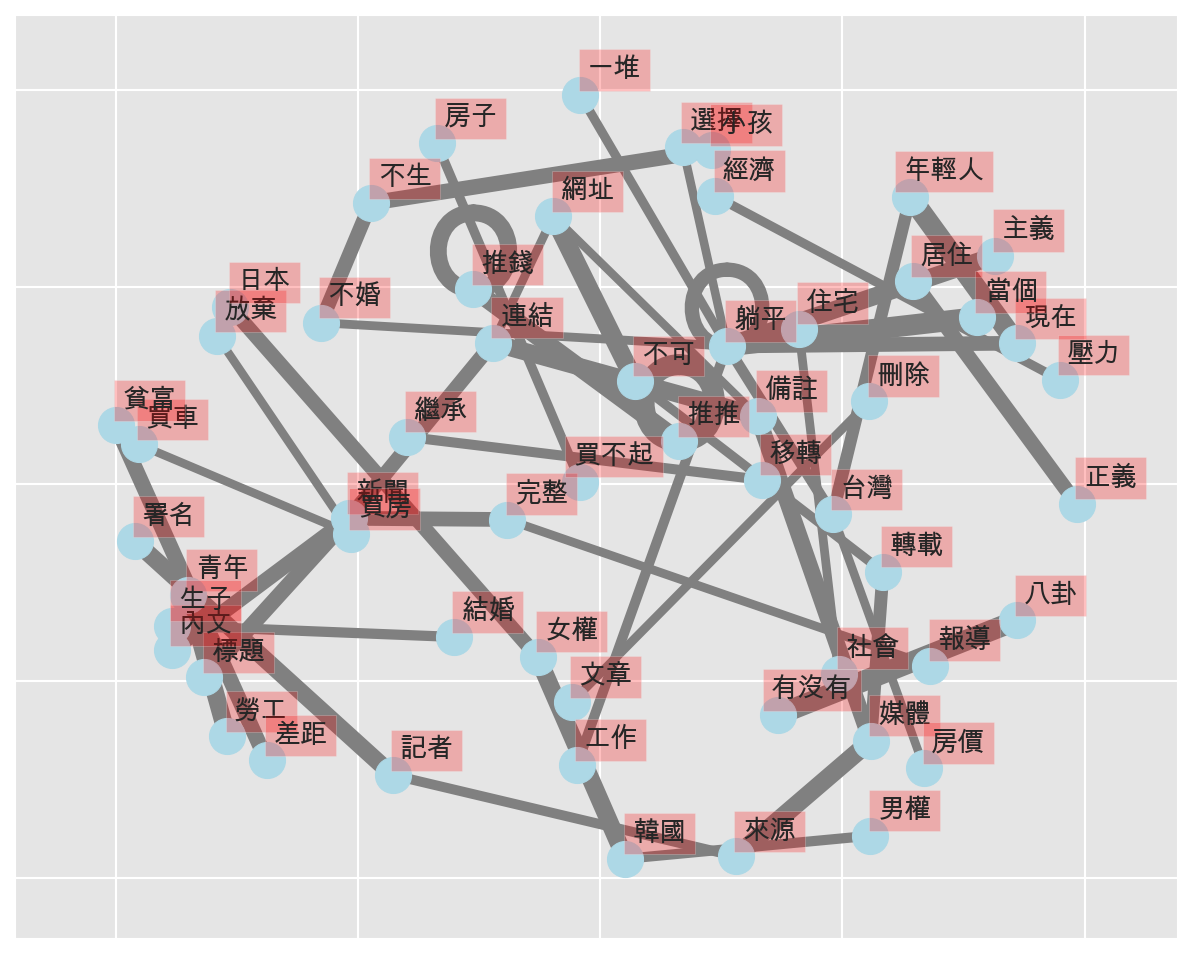

In [117]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

### 6.8 計算文章相似度

In [118]:
data_cos= MetaData.copy()
data_cos = data_cos.loc[:,["artTitle","artDate","artUrl","sentence"]]
# 需要改成使用空格連接斷好的詞
data_cos['word'] = data_cos.sentence.apply(getToken).map(' '.join)
data_cos.head(3)

,artTitle,artDate,artUrl,sentence,word
0,[閒聊]沒有工作的一年~~,2022-05-03 19:54:49,https://www.ptt.cc/bbs/China-Drama/M.165157889...,都第集了竟然沒人開這一檔閒聊這是一部顛覆的都市情感劇沒有白富美的女一也沒有高富帥的男一也沒有...,第集 沒人開 這一 閒聊 一部 顛覆 都市 情感 富美 富帥 北上 生活 女二何 小雨 躺平...
1,[心得]沒有工作的一年,2023-11-03 14:04:20,https://www.ptt.cc/bbs/China-Drama/M.169899146...,因為在滑到沒有工作的一年給打工人的大金句才開始注意到這部陸劇沒有工作的一年總共也才集本來只是...,滑到 工作 一年 打工 金句 注意到 這部 陸劇 工作 一年 總共 本來 打發 時間 沒想到...
2,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30 11:12:41,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,備註請放最後面違者新聞文章刪除媒體來源新唐人記者署名羅婷婷完整新聞標題中國人躺平火爆網路當局...,備註 請放 最後 違者 新聞 文章 刪除 媒體 來源 唐人 記者 署名 婷婷 完整 新聞 標...


In [120]:
# Bag of Word
# 篩選至少出現在5篇文章以上的詞彙
vectorizer = CountVectorizer(min_df=5)
X = vectorizer.fit_transform(data_cos["word"])
vocabulary = vectorizer.get_feature_names_out()
# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一下,一人,一代,一件,一份,一位,一出,一半,一句,一台,...,高雄,高齡化,鬼島,魯蛇,麥當勞,麻煩,黑道,默默,黨主席,鼓勵
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,0,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
622,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
623,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [121]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  
# print(tfidf.toarray())

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一下,一人,一代,一件,一份,一位,一出,一半,一句,一台,...,高雄,高齡化,鬼島,魯蛇,麥當勞,麻煩,黑道,默默,黨主席,鼓勵
0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,0.000000,0.082527,0.0,0.0,0.079368,0.086483,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
621,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
622,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
623,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.152859,0.0,...,0.0,0.0,0.0,0.0,0.0,0.155995,0.0,0.0,0.0,0.0


In [122]:
# 計算 cosine_similarity
def cosine_similarity(vector):
    cos_list = []
    for i in tfidf.toarray():
        score = np.dot(vector, i)  / (norm(vector) * norm(i))
        cos_list.append(score)
    df = pd.DataFrame(cos_list, columns=["cos_similarity"])
    return df

In [123]:
print(tfidf.toarray()[1])
cos_df = cosine_similarity(tfidf.toarray()[1])

[0. 0. 0. ... 0. 0. 0.]


In [124]:
# 第一篇文章和其他文章的相似程度
cos_df.head(10)

,cos_similarity
0,0.227699
1,1.000000
2,0.094715
3,0.019635
4,0.041523
5,0.038439
6,0.002328
7,0.114824
8,0.069668
9,0.001893


In [125]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
# cos_df.head()
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
1,1.000000,[心得]沒有工作的一年,https://www.ptt.cc/bbs/China-Drama/M.169899146...
472,0.231915,[問卦]台灣過20年後會出現自殺潮嗎?,https://www.ptt.cc/bbs/Gossiping/M.1676879367....
161,0.227839,Re:[問卦]在台灣要工作多久才有辦法躺平,https://www.ptt.cc/bbs/Gossiping/M.1635488904....
0,0.227699,[閒聊]沒有工作的一年~~,https://www.ptt.cc/bbs/China-Drama/M.165157889...
471,0.202153,Re:[問卦]沒人發現工作一輩子什麼都沒有嗎?,https://www.ptt.cc/bbs/Gossiping/M.1676777245....
245,0.199167,[新聞]美國也出現躺平族！「反工作」崛起離,https://www.ptt.cc/bbs/Gossiping/M.1641829791....
341,0.193052,[新聞]薪水苦、房價飆年輕人看不見希望！揭密,https://www.ptt.cc/bbs/Gossiping/M.1653227250....
620,0.189829,[台北]徳勝科技徵行政助理,https://www.ptt.cc/bbs/job/M.1641443264.A.EF6....
401,0.183497,[問卦]人生的意義就是[存活]?!,https://www.ptt.cc/bbs/Gossiping/M.1665388231....
56,0.176135,Re:[新聞]8年級湧大量「躺平族」！不婚不生放棄掙,https://www.ptt.cc/bbs/Gossiping/M.1633000227....


## 7. 結論



1.   
